In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

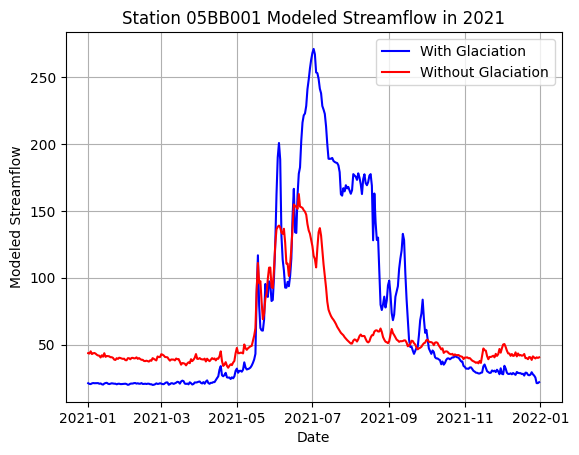

In [2]:
glac_data = pd.read_csv("modeled_streamflow_results/glaciated_predictions.csv", index_col=0)
non_glac_data = pd.read_csv("modeled_streamflow_results/non_glaciated_predictions.csv", index_col=0)
diff_data = glac_data - non_glac_data

year = 2021
glac_data.index = pd.to_datetime(glac_data.index)
non_glac_data.index = pd.to_datetime(non_glac_data.index)

glac_subset = glac_data[glac_data.index.year == year]
non_glac_subset = non_glac_data[non_glac_data.index.year == year]
diff_subset = glac_subset - non_glac_subset

station = '05DA009'

plt.plot(glac_subset.index, glac_subset[station], label='With Glaciation', color='blue')
plt.plot(non_glac_subset.index, non_glac_subset[station], label='Without Glaciation', color='red')
# plt.plot(diff_subset.index, diff_subset[station], label='Difference', color='green')
plt.plot()
plt.xlabel('Date')
plt.ylabel('Modeled Streamflow')
plt.title(f'Station 05BB001 Modeled Streamflow in {year}')
plt.legend()
plt.grid(True)
plt.show()